In [1]:
import sys
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [3]:
j = janet.boot(uni, index=258)

Already have data downloaded for Gaia ID 1923544057484996224.
If you want to check for new data, run `janet.update()`.
### Running Simple Astropy Lomb-Scargle on Sector 16 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 17 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector all on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 1923544057484996224 ###
### Saved results ###
### Running Wavelet Estimation on star 1923544057484996224 ###


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



### Completed Wavelet Estimation on star 1923544057484996224 ###
### Saved results ###
### Running ACF Estimation on star 1923544057484996224 ###
### Completed ACF Estimation on star 1923544057484996224 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###

------ Decoding Overall Period Flag 1 ------
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 

### Saved results ###


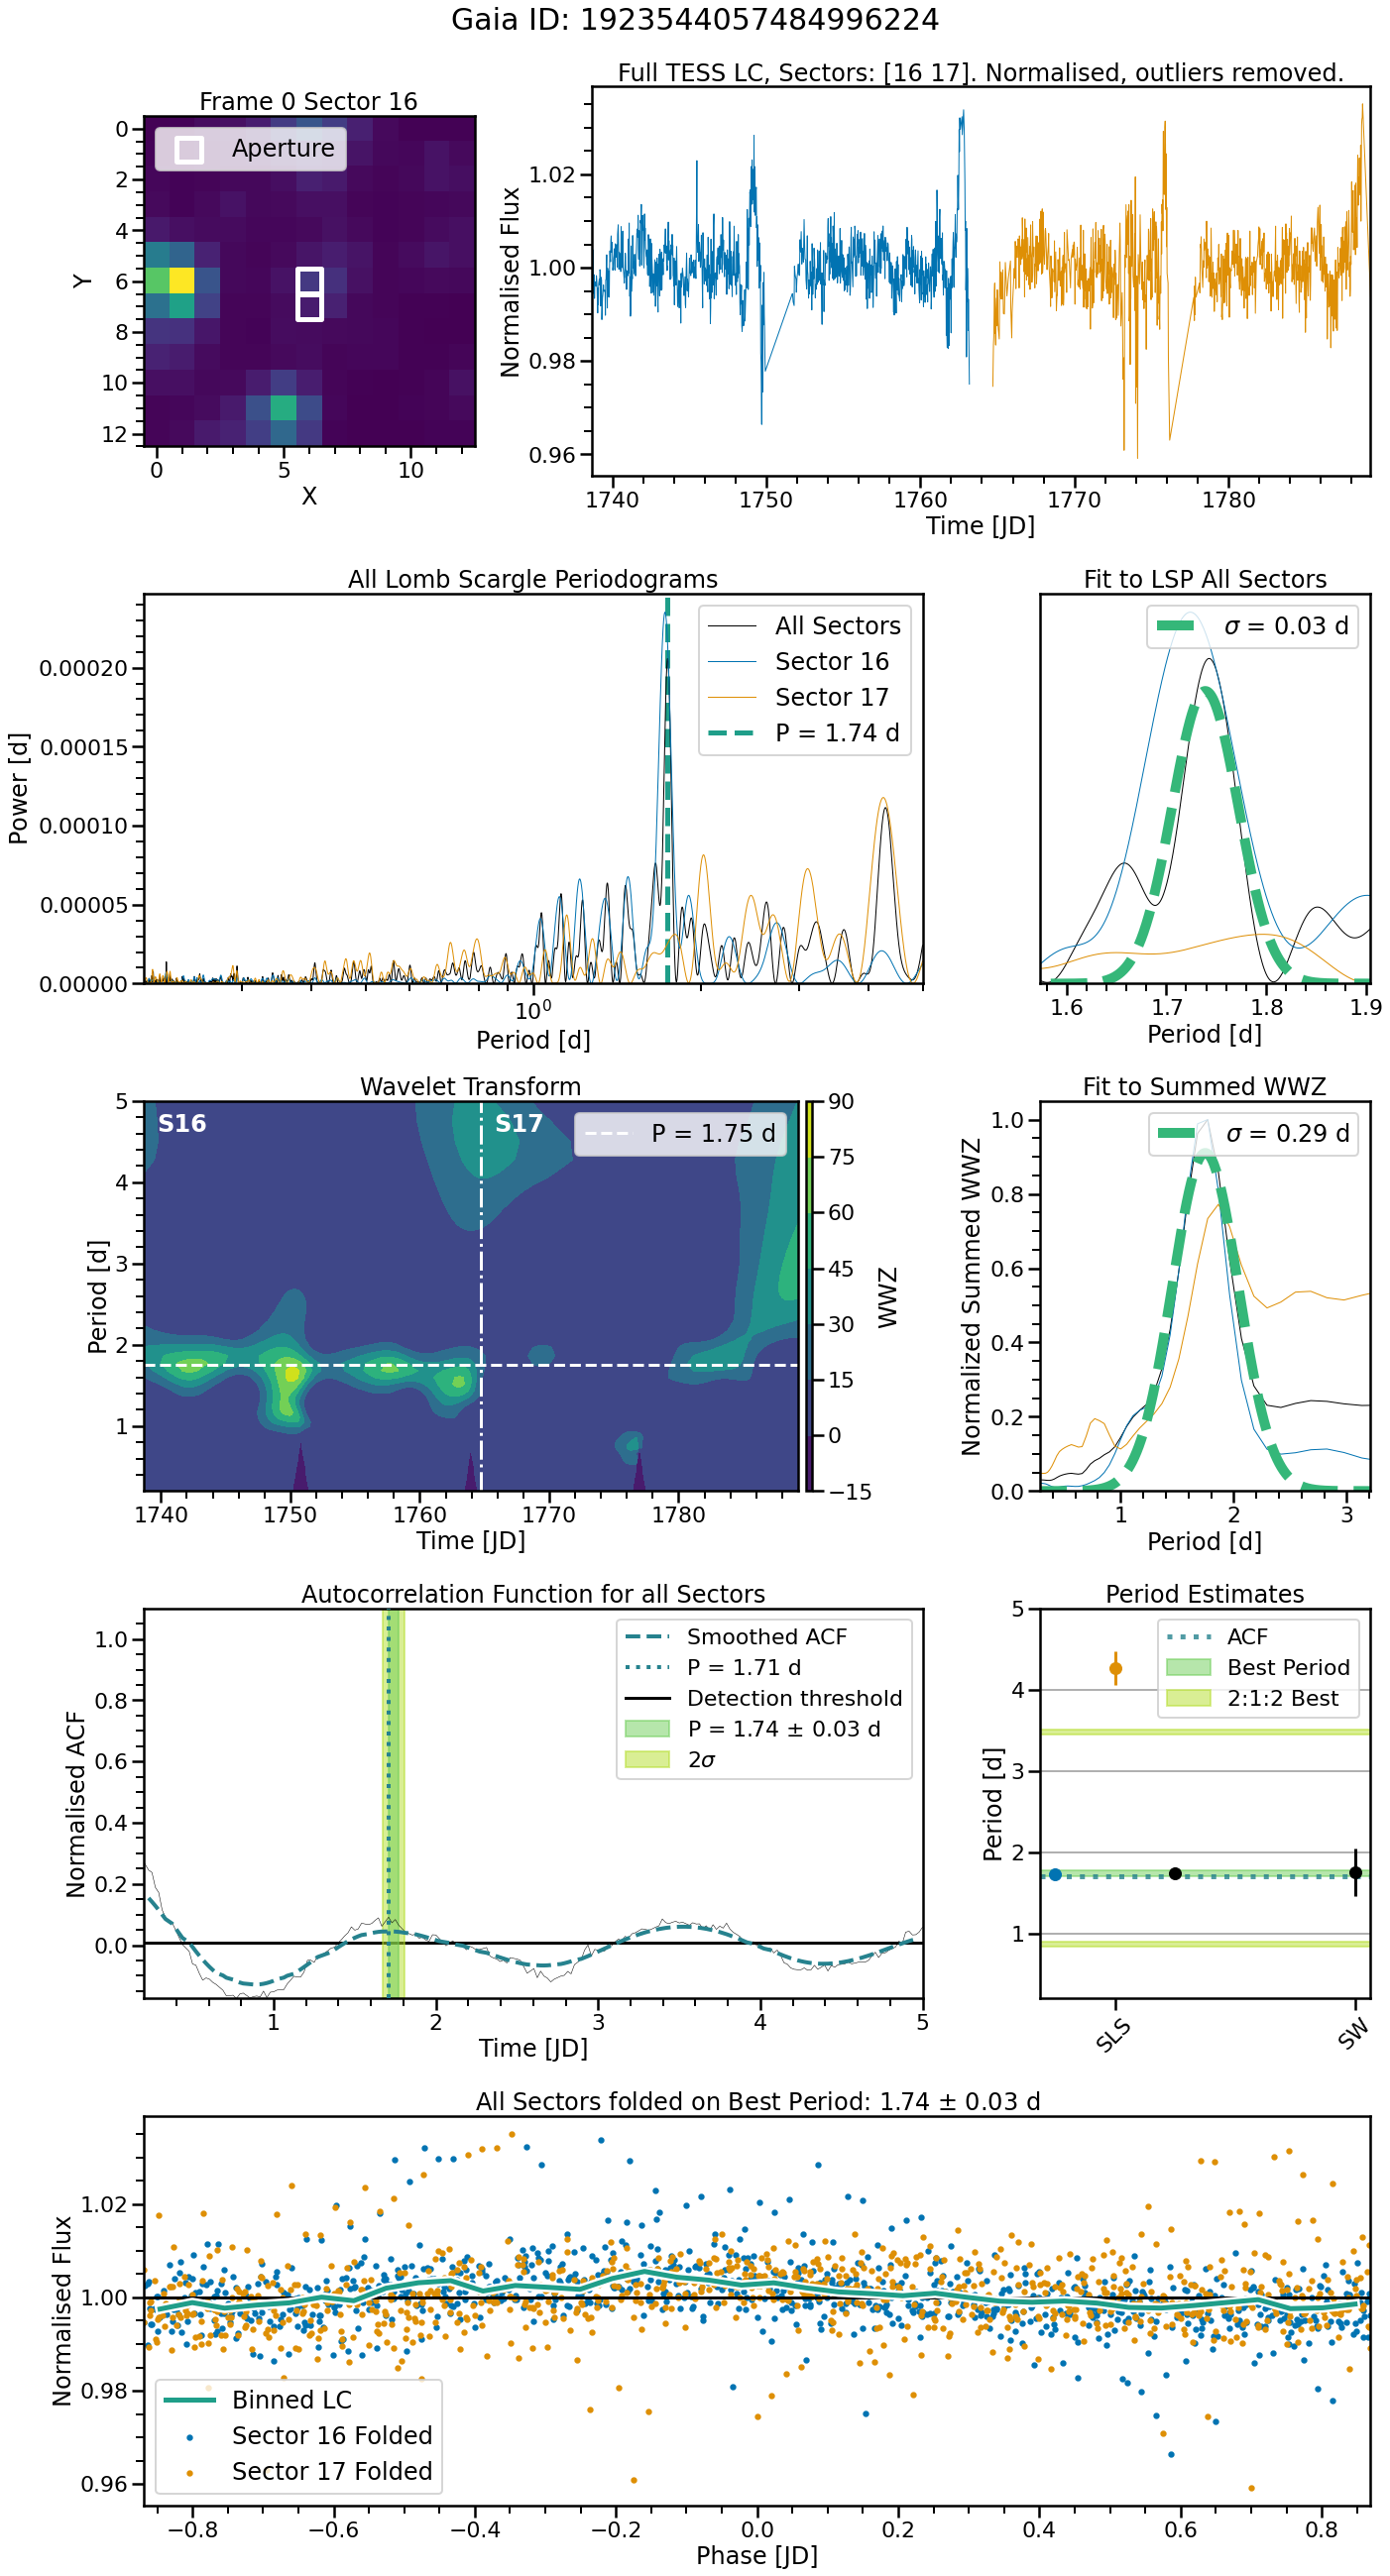

In [4]:
j.run(period_range = (0.2, 5))

### Adding new features

In [5]:
sys.exit()

SystemExit: 

/Users/Anaconda/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm

In [ ]:
acfsmoo = j.void['acfsmoo']
wt = j.void['wt']
nus = wt.nus
wwz = j.void['wwz']

In [ ]:
acfsmoolc = lk.LightCurve(time = j.void['acflc'].time.value, flux = acfsmoo)

In [ ]:
Model = pm.Model()
P = acfsmoolc.time.value
F = acfsmoolc.flux.value

with Model:
    A0 = pm.Uniform('A0', 0., 1., testval=0.05)
    A1 = pm.Uniform('A1', 0., 10., testval=0.5)
    yy = pm.Deterministic('yy', (1-A0)*np.exp(-P/A1) + A0)
    y = pm.Normal('like', mu=yy, sigma = np.std(F),
                 observed=F)

In [ ]:
with Model:
    trace = pm.sample()

In [ ]:
yy = np.median(trace['yy'], axis=0)
normacf = acfsmoolc - yy

In [ ]:
binned = normacf.bin()